In [1]:
%pylab inline
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn import cross_validation
import pandas as pd

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

store = pd.HDFStore('store.h5')

Populating the interactive namespace from numpy and matplotlib


Using Theano backend.


In [2]:
store

<class 'pandas.io.pytables.HDFStore'>
File path: store.h5
/data                                frame        (shape->[1000,9443]) 
/feature_score                       series       (shape->[28329])     
/feature_score_for_0                 series       (shape->[28329])     
/feature_score_for_1                 series       (shape->[28329])     
/feature_score_for_2                 series       (shape->[28329])     
/feature_score_for_3                 series       (shape->[28329])     
/feature_score_for_4                 series       (shape->[28329])     
/feature_score_for_5                 series       (shape->[28329])     
/feature_score_for_6                 series       (shape->[28329])     
/feature_score_rf                    series       (shape->[28329])     
/feature_selected_data               frame        (shape->[1000,3201]) 
/feature_selected_data_rf            frame        (shape->[1000,11717])
/gene_info                           frame        (shape->[300,9443])  
/label

In [3]:
data = store['onehot_data']
label = store['label']

# random forest 特征选择

In [4]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

X, y = data.as_matrix(), label.as_matrix().flat
clf = ExtraTreesClassifier(n_estimators=250,random_state=0)
clf = clf.fit(X, y)

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
print X.shape, X_new.shape

(1000, 28329) (1000, 11717)


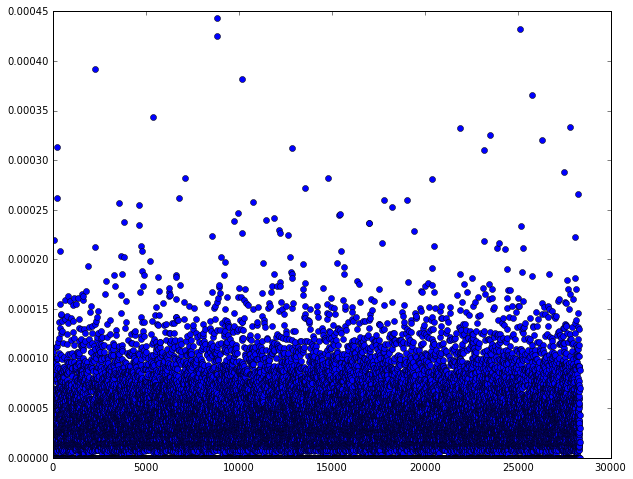

In [16]:
importances = clf.feature_importances_
plot(importances,'o')

In [6]:
idx_rf=importances>mean(importances)
print sum(idx_rf)
print sum(importances[idx_rf])

11717
0.771854628535


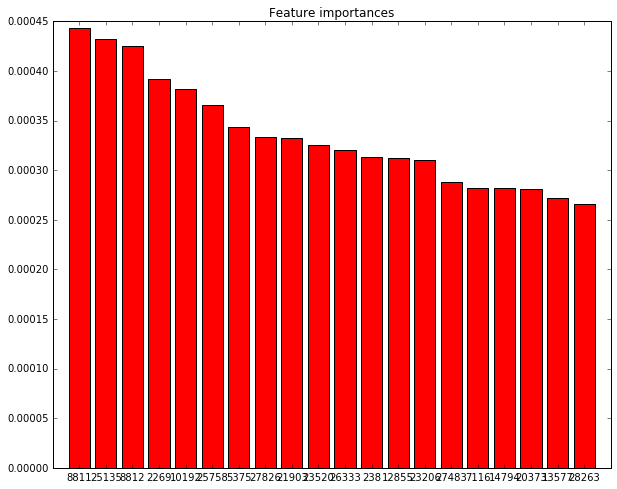

In [17]:
N=20
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
figure()
title("Feature importances")
bar(range(N), importances[indices][:N], color="r", align="center")
xticks(range(N), indices)
xlim([-1,N])
show()

In [8]:
store['selected_idx_rf']=pd.Series(idx_rf)
store['feature_selected_data_rf']=pd.DataFrame(X_new)
store['feature_score_rf']=pd.Series(clf.feature_importances_)
store.flush(fsync=True)
print store

<class 'pandas.io.pytables.HDFStore'>
File path: store.h5
/data                                frame        (shape->[1000,9443]) 
/feature_score                       series       (shape->[28329])     
/feature_score_for_0                 series       (shape->[28329])     
/feature_score_for_1                 series       (shape->[28329])     
/feature_score_for_2                 series       (shape->[28329])     
/feature_score_for_3                 series       (shape->[28329])     
/feature_score_for_4                 series       (shape->[28329])     
/feature_score_for_5                 series       (shape->[28329])     
/feature_score_for_6                 series       (shape->[28329])     
/feature_score_rf                    series       (shape->[28329])     
/feature_selected_data               frame        (shape->[1000,3201]) 
/feature_selected_data_rf            frame        (shape->[1000,11717])
/gene_info                           frame        (shape->[300,9443])  
/label

# RandomizedLogisticRegression 特征选择

- Stability selection Nicolai Meinshausen, Peter Buhlmann Journal of the Royal Statistical Society: Series B Volume 72, Issue 4, pages 417-473, September 2010 DOI: 10.1111/j.1467-9868.2010.00740.x

In [9]:
from sklearn.linear_model import RandomizedLogisticRegression
with warnings.catch_warnings():
    warnings.simplefilter('ignore', DeprecationWarning)
    clf2 = RandomizedLogisticRegression().fit(X,y)

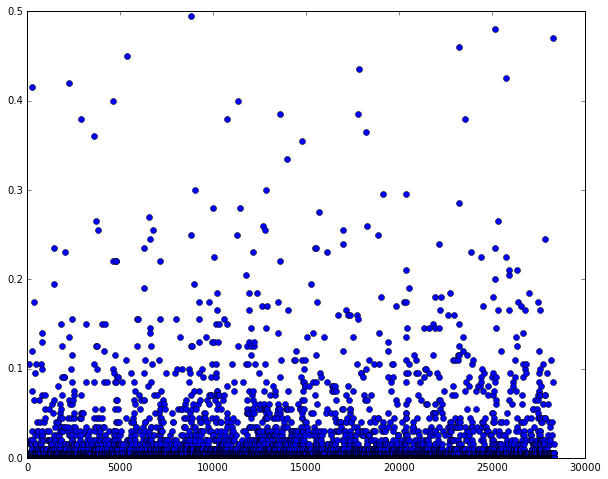

In [18]:
plot(clf2.scores_,'o')

In [11]:
idx=clf2.scores_>mean(clf2.scores_)
print sum(idx)
print sum(clf2.scores_[idx])
print idx.shape

3232
99.295
(28329,)


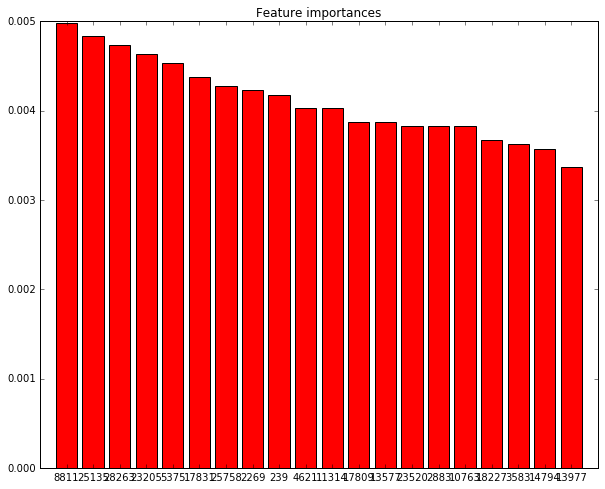

In [19]:
N=20
indices = np.argsort(clf2.scores_)[::-1]

figure()
title("Feature importances")
bar(range(N), (clf2.scores_/clf2.scores_.sum())[indices][:N], color="r", align="center")
xticks(range(N), indices)
xlim([-1,N])
show()

# 选择使用Stability selection的方法，使用randomized logistic regression

In [20]:
X_new2 = X[:,idx]
print X_new2.shape

(1000, 3232)


In [21]:
print pd.Series(idx)

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
28299    False
28300    False
28301    False
28302    False
28303    False
28304    False
28305    False
28306    False
28307    False
28308    False
28309     True
28310    False
28311     True
28312    False
28313    False
28314    False
28315    False
28316    False
28317    False
28318    False
28319    False
28320     True
28321    False
28322    False
28323     True
28324    False
28325     True
28326    False
28327    False
28328    False
dtype: bool


In [22]:
store['selected_idx']=pd.Series(idx)
store['feature_selected_data']=pd.DataFrame(X_new2)
store['feature_score']=pd.Series(clf2.scores_/clf2.scores_.sum())
store.flush(fsync=True)
print store
store.close()

<class 'pandas.io.pytables.HDFStore'>
File path: store.h5
/data                                frame        (shape->[1000,9443]) 
/feature_score                       series       (shape->[28329])     
/feature_score_for_0                 series       (shape->[28329])     
/feature_score_for_1                 series       (shape->[28329])     
/feature_score_for_2                 series       (shape->[28329])     
/feature_score_for_3                 series       (shape->[28329])     
/feature_score_for_4                 series       (shape->[28329])     
/feature_score_for_5                 series       (shape->[28329])     
/feature_score_for_6                 series       (shape->[28329])     
/feature_score_rf                    series       (shape->[28329])     
/feature_selected_data               frame        (shape->[1000,3232]) 
/feature_selected_data_rf            frame        (shape->[1000,11717])
/gene_info                           frame        (shape->[300,9443])  
/label

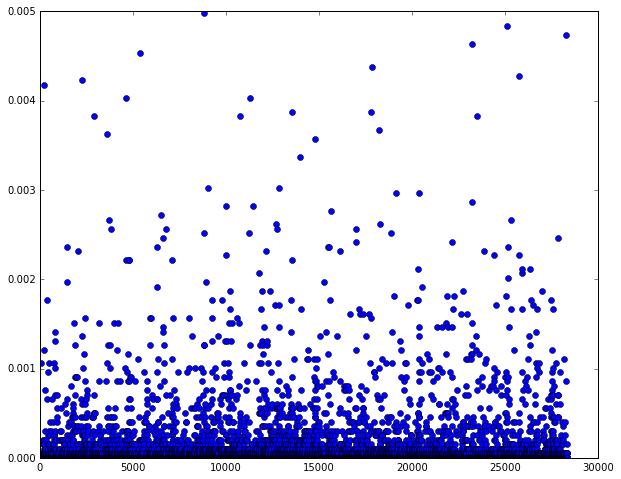

In [23]:
store = pd.HDFStore('store.h5')
plot(store['feature_score'],'o')
plot(store['feature_score_rf'],'0')

In [16]:
print